This file reproduce the plots present of the paper on the Averaging tasks dataset based on the data produced by running reproduce_averaging0.py and reproduce_averaging1.py.

The parameters on each of the two experiments must correspond to the parameter of reproduce_averaging0.py (for the first part) and reproduce_averaging1.py (for the second part). 

## Analysis on Approximate consensus task

### 1. Two worlds topology with a varying number of Byzantines (reproduce_averaging0.py)


In [1]:

# import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl


# sns.set_theme(style='white')
seeds=tuple(range(1))


params_averaging = {
  "evaluation-delta": 1,
  "nb-steps": 100,
  "nb-honests":26,
  "nb-params":5,
  "random-init":"normal_2", # Here 'normal' intialize nodes'parameter with N(0,I_5), #'normal_2' add +- (5,0,0,0,0) depending on the index
  "topology-name" : "two_worlds",
  "topology-weights": "metropolis",
  "topology-hyper":8,
  }

# Hyperparameters to test
topology_hypers = [params_averaging["topology-hyper"]]
gars = ["CSplus_RG", "GTS_RG", "CShe_RG", 'IOS']
attacks = ["sparse_little", "sparse_empire",  "spectral" , "dissensus" ]
dataset = "averaging"
params_common = params_averaging
byzcounts = [i for i in range(1,16)]
seeds = tuple(range(6))
params = params_common.copy()
params["nb-workers"] = params["nb-honests"]

result_directory = "results-data/acp/"
plot_directory = "results-plot/"


algorithms_name = {
          "CSplus_RG":r"CS$_{+}$-RG",
          "GTS_RG":r"GTS-RG",
          "IOS":r"IOS",
          "CShe_RG":r"ClippedGossip",
          "dsgd":r"D-SGD",
          "cva":r"$\rm GTS$-$\rm RG$",
          "trmean":"BRIDGE",
          "rfa":"MoGM",
          "centeredclip":r"$\rm CS_{He}$-$\rm RG$",
          "cgplus":r"$CS$_{ours}$-RG$"
        }


attack_name = {
          "dissensus":"Dissensus", 
          "spectral":"SpH" , 
          "sparse_empire":"FOE", 
          "sparse_little":"ALIE"
        }


In [2]:
def aggregate_experiment(name_experiment, seeds=seeds, result_directory=result_directory):
    """
    aggregate values of the experiments, output the min, max, mean, std of each experiment batch.
    """
    df_list = [pd.read_csv(result_directory + "/" + name_experiment + "-" +str(seed) + "/eval", delimiter='\t') for seed in seeds]

    stacked_df = np.stack([df[['Average loss']].values for df in df_list], axis=2)

    stacked_df = stacked_df / stacked_df[0,...][None,...]
    # Calculate mean, std, min, and max across the third dimension (the DataFrame axis)

    mean_loss = stacked_df[:, 0, :].mean(axis=1)
    std_loss = stacked_df[:, 0, :].std(axis=1)
    min_loss = stacked_df[:, 0, :].min(axis=1)
    max_loss = stacked_df[:, 0, :].max(axis=1)

    # Create a new DataFrame to store the results, with "# Step number" as index
    result_df = pd.DataFrame({
        'mean-loss': mean_loss,
        'std-loss': std_loss,
        'min-loss': min_loss,
        'max-loss': max_loss
    }, index=df_list[0]["# Step number"])

    return result_df

### Ploting the loss as a function of the number of Byzantin neighbors.

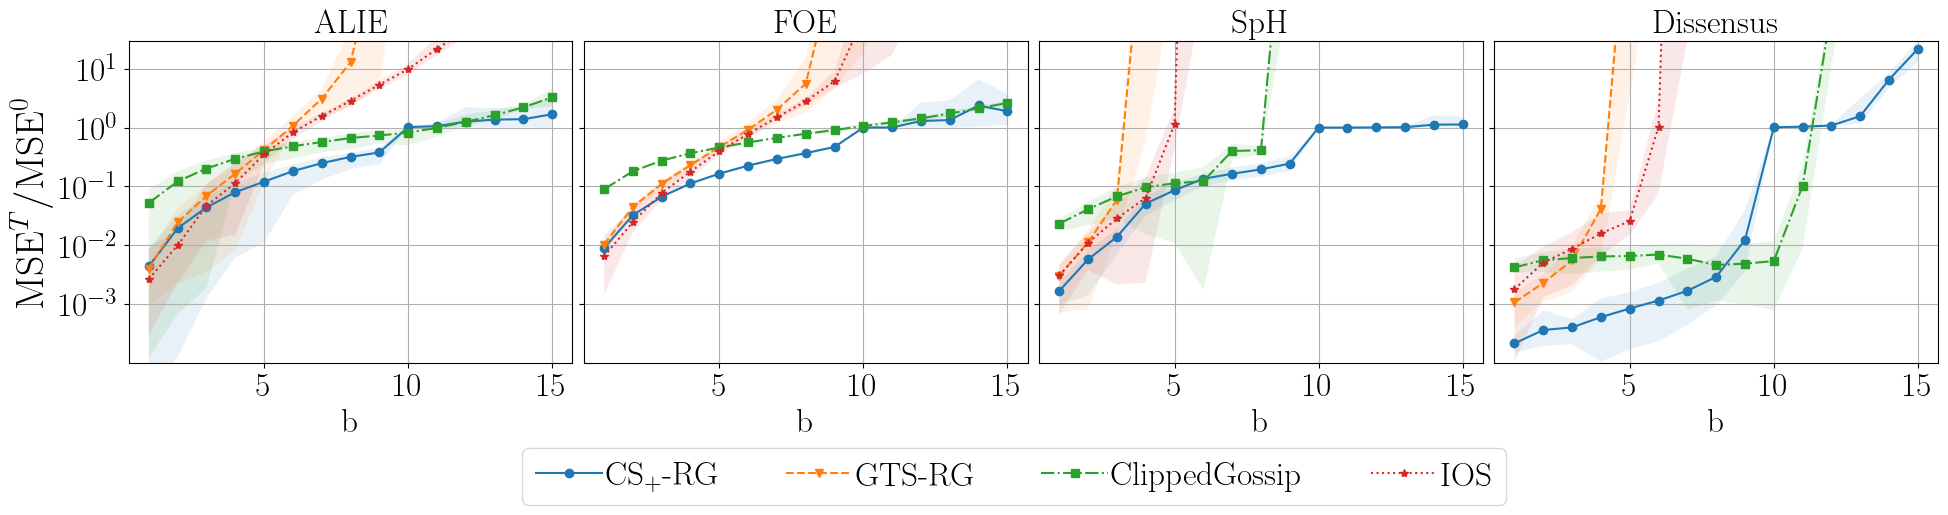

In [3]:
size=24
size_legend=24
mpl.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'font.serif': 'Roman',
    'font.weight':'bold',
    #'legend.fontweight':'bold',
    'text.usetex': True,
    'pgf.rcfonts': False,
    "axes.grid" : True,
    'font.size': size,
    'axes.labelsize':size,
    'axes.titlesize':size,
    'figure.titlesize':size,
    'xtick.labelsize':size,
    'ytick.labelsize':size,
    'legend.fontsize':size_legend
})

palette = sns.color_palette('colorblind') # 
colors = colors = plt.rcParams['axes.prop_cycle'].by_key()['color']# [palette[i] for i in range(5)] # ['#383F51','#B0413E','#FEA82F','#43AA8B','#6C7D47']# 
markers = ['o', 'v', 's', '*', 'd']
dashstyle = ['-', '--', '-.', ':', ':']
c=[]
m=[]

fig, axs = plt.subplots(1, len(attacks), figsize=(20, 5), sharex=False, sharey=True)

for attack_id, attack in enumerate(attacks):
    for gar_id, gar in enumerate(gars):
        X=[]
        Y=[]
        Yerr=[]
        Ymin=[]
        Ymax=[]
        for f in byzcounts:
            #Gar generic
            name_experiment = f"{dataset}-{attack}-{gar}-f_{f}-h_{params['nb-honests']}-{params["topology-name"]}_{params["topology-hyper"]}"
            df_expe = aggregate_experiment(name_experiment)
            X.append(f)
            try:
                y = df_expe.loc[params["nb-steps"], "mean-loss"] #cols[0].loc[190:200, "Cross-accuracy"].mean()
            except:
                print(f"attack {attack} gar {gar} byzcount {f}")
                print(df_expe)
                
            if np.isnan(y):
                Y.append(1000)
            else:
                Y.append(y)
            
            Yerr.append(df_expe.loc[params["nb-steps"], "std-loss"])
            Ymin.append(df_expe.loc[params["nb-steps"], "min-loss"])
            Ymax.append(df_expe.loc[params["nb-steps"], "max-loss"])
        
        Y=np.array(Y)
        Yerr=np.array(Yerr)

        axs[attack_id].plot(X,Y, color=colors[gar_id], marker=markers[gar_id], label=algorithms_name[gar], linestyle=dashstyle[gar_id])
        axs[attack_id].fill_between(X, Ymax, Ymin, facecolor=colors[gar_id], alpha=0.1)

    axs[attack_id].set_title(attack_name[attack])
    axs[attack_id].set_xlabel(r"b")
    #axs[attack_id].set_xticks(ticks=byzcounts)
axs[0].set_ylabel(r"MSE$^{T}/$MSE$^0$",rotation=90,size="large")

axs[0].set_yscale("log")
axs[0].set_yticks([1e-3,1e-2,0.1, 1, 10])
axs[0].set_ylim(1e-4,3e1)


handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.52, 0.05), ncol=5, labelspacing=0.1, handletextpad=0.1, borderaxespad=0)
fig.tight_layout(w_pad=0.2)


name_plot = f"loss_averaging-f_{byzcounts[0]}:{byzcounts[-1]}-n_{params['nb-honests']}-{params["topology-name"]}_{params["topology-hyper"]}"
fig.savefig(plot_directory + name_plot+'.pdf',bbox_inches='tight')

## 2. Erdos Renyi topology with a fixed number of Byzantines, but a varying connectivity (reproduce_averaging1.py)

In [4]:
import topology

# Base parameters for the Averaging experiments
params_averaging = {
  "evaluation-delta": 1,
  "nb-steps": 100,
  "nb-honests":20,
  "nb-params":5,
  "random-init":"normal", ### actually, the choice is only 'normal' or 'normal_2'
  "topology-name" : "Erdos_Renyi", #"two_worlds",
  "topology-weights": "unitary",
  }

# Hyperparameters to test
topology_hypers = list(np.linspace(0.3,1,15))
gars = ["CSplus_RG","GTS_RG", "CShe_RG", 'IOS']#, 'trmean']
attacks = ["sparse_little", "sparse_empire", "spectral", "dissensus" ]#, "signflipping", "labelflipping"]
dataset = "averaging"
params = params_averaging
f = 4 #[i for i in range(1,16)]
seeds = tuple(range(6))

size=24
size_legend=24
mpl.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'font.serif': 'Roman',
    'font.weight':'bold',
    #'legend.fontweight':'bold',
    'text.usetex': True,
    'pgf.rcfonts': False,
    "axes.grid" : True,
    'font.size': size,
    'axes.labelsize':size,
    'axes.titlesize':size,
    'figure.titlesize':size,
    'xtick.labelsize':size,
    'ytick.labelsize':size,
    'legend.fontsize':size_legend
})
palette = sns.color_palette('colorblind') # 
colors = colors = plt.rcParams['axes.prop_cycle'].by_key()['color']# [palette[i] for i in range(5)] # ['#383F51','#B0413E','#FEA82F','#43AA8B','#6C7D47']# 
markers = ['o', 'v', 's', '*', 'd']
dashstyle = ['-', '--', '-.', ':', ':']
c=[]
m=[]

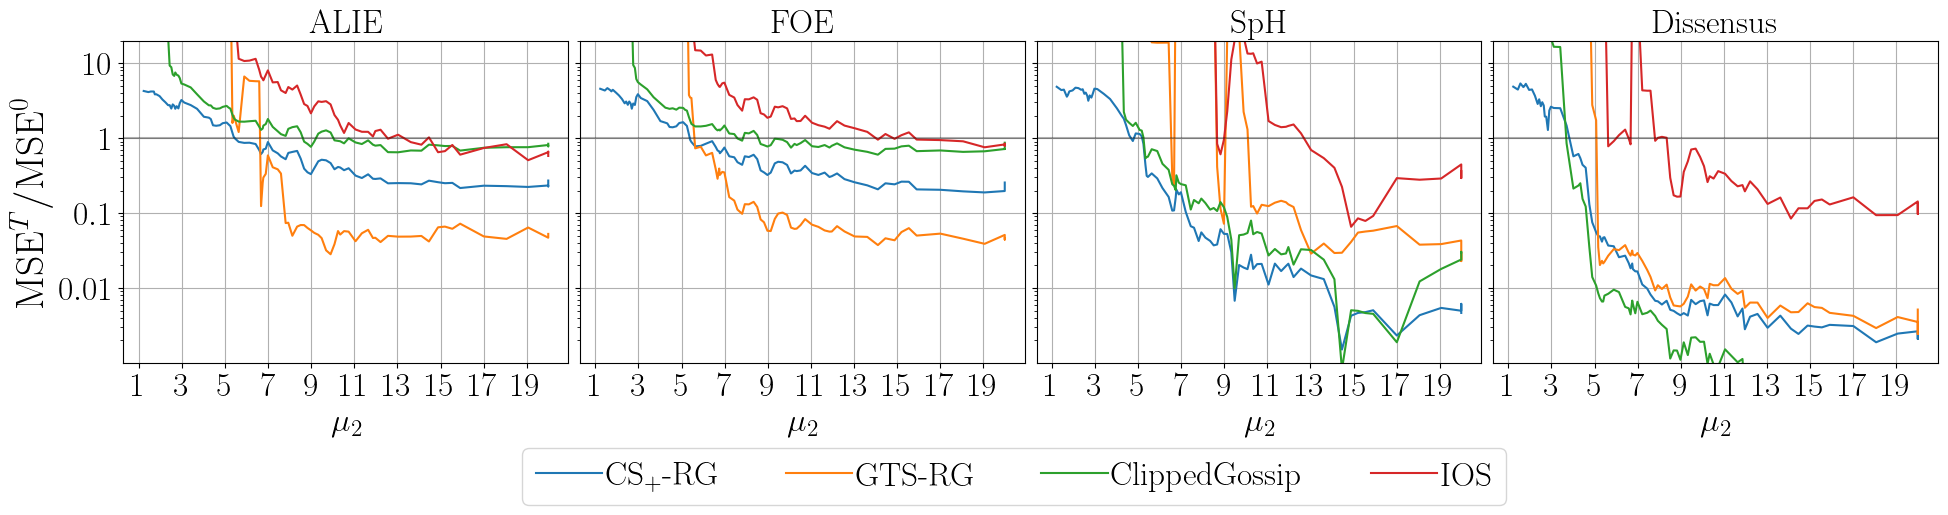

In [ ]:

infty_value=1000

fig, axs = plt.subplots(1, len(attacks), figsize=(20, 5), sharex=False, sharey=True)


for attack_id, attack in enumerate(attacks):
    for gar_id, gar in enumerate(gars):
        X=[]
        Y=[]
        for top_hyper in topology_hypers:
            #Gar generic
            name_experiment = f"{dataset}-{attack}-{gar}-f_{f}-h_{params['nb-honests']}-{params["topology-name"]}_{top_hyper}"
            
            for seed in seeds:  
                path = result_directory + name_experiment + "-" +str(seed) + "/eval"
                try: 
                    df_seed = pd.read_csv(path, delimiter='\t')
                except:
                    print(f"file not found:{path}")
                    continue

                net = topology.create_graph("Erdos_Renyi", size=params['nb-honests'], 
                    hyper=top_hyper, seed=seed, byz=0, weights_method='unitary')

                X.append(net.algebraic_connectivity)
                out = df_seed[['Average loss']].values[-1,:]
                Y.append(out[0])
                        

        Y=np.array(Y)
        nan_indices = (np.isnan(Y) | (Y>infty_value))
        Y = np.where(nan_indices, infty_value, Y)
        X=np.array(X)
        indices_sort = np.argsort(X)
        X=X[indices_sort]
        Y=Y[indices_sort]

        smooth_length=4
        Y = np.convolve(Y, np.ones(smooth_length)/smooth_length,mode="valid")
        X = np.convolve(X, np.ones(smooth_length)/smooth_length,mode="valid")
        
        

        axs[attack_id].plot(X,Y, color=colors[gar_id], label=algorithms_name[gar]) #linestyle=dashstyle[gar_id] marker=markers[gar_id],
        # axs[attack_id].fill_between(X, Ymin, Ymax, facecolor=colors[gar_id], alpha=0.2)

    axs[attack_id].set_title(attack_name[attack])
    axs[attack_id].set_xlabel(r"$\mu_2$")
    axs[attack_id].set_xticks([5,10,15,20])
    axs[attack_id].axhline(y=1, color="black", alpha=0.3)
    ticks = [i for i in range(1,21,2)]
    # ticks_label = []
    # for i in ticks:
    #     if i%2==0:
    #         ticks_label.append(str(i))
    #     else:
    #         pass
    #         #ticks_label.append('')
    axs[attack_id].set_xticks(ticks) #, labels=ticks_label)
axs[0].set_ylabel(r"MSE$^{T}/$MSE$^0$",rotation=90,size="large")
axs[0].set_yscale("log")
axs[0].set_yticks([1e-2, 1e-1, 1, 10], labels=[r"$0.01$", r"$0.1$", r"$1$", '10'])
axs[0].set_ylim(1e-3,2e1)


handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.52, 0.05), ncol=5, labelspacing=0.1, handletextpad=0.1, borderaxespad=0)
fig.tight_layout(w_pad=0.2)


name_plot = f"loss_averaging-f_{f}-n_{params['nb-honests']}-{params["topology-name"]}"
fig.savefig(plot_directory + name_plot+'.pdf',bbox_inches='tight')